# Transfer Learning with VGG16

In this notebook, I will go over steps to retrain VGG16 net for the skin cancer dataset.

In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load in the Dataset

In [2]:
X_train = np.load("/floyd/input/skin_cancer_192_256/256_192_train.npy")

In [3]:
y_train = np.load("/floyd/input/skin_cancer_192_256/train_labels.npy")

In [4]:
X_val = np.load("/floyd/input/skin_cancer_192_256/256_192_val.npy")

In [5]:
y_val = np.load("/floyd/input/skin_cancer_192_256/val_labels.npy")

## Reshape the Dataset

In [6]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [7]:
y_train.shape, y_val.shape

((8111,), (902,))

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

## Load in Pretrained VGG16 Model

In [10]:
pre_trained_model = VGG16(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

In [11]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [12]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 512)


## Define the Model

In [13]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 64, 128)       0         
__________

## Training

### Feature-Extraction

If performing fine tuning directly would result in a huge gradient, so it's better that we perform 3 epochs of feature extraction first so that weights of the final fully connected layer aren't completely random. The intuition for this is that if we don't perform feature-extraction, then the gradient will be too large and will change the pretrained weights too much.

In [15]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [16]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

Epoch 1/3
126/126 [==============================] - 91s 720ms/step - loss: 1.2934 - acc: 0.6207 - val_loss: 1.0926 - val_acc: 0.6652
Epoch 2/3
126/126 [==============================] - 84s 667ms/step - loss: 1.0835 - acc: 0.6666 - val_loss: 0.9895 - val_acc: 0.6674
Epoch 3/3
126/126 [==============================] - 85s 676ms/step - loss: 1.0268 - acc: 0.6686 - val_loss: 1.0094 - val_acc: 0.6588


### Fine Tuning Model

Let's fine tune the last convolutional block of VGG net. I only use learning_rate = 0.0001 with very high momentum = 0.9 and train for 35 epochs only so that the original weights of pretrained VGG net won't be changed too much. learning_rate_reduction function is used and will halve the learning_rate whenever the validation accuracy plateaus for 3 epochs. 

In [17]:
for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True

In [18]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 64, 128)       0         
__________

By setting the last convolutional block to trainable, we are now retraining for half of the hyperparameters

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [21]:
batch_size = 64
epochs = 30
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[learning_rate_reduction])

Epoch 1/30
126/126 [==============================] - 89s 707ms/step - loss: 0.8724 - acc: 0.6997 - val_loss: 0.8149 - val_acc: 0.6964
Epoch 2/30
126/126 [==============================] - 85s 673ms/step - loss: 0.7467 - acc: 0.7335 - val_loss: 0.7273 - val_acc: 0.7455
Epoch 3/30
126/126 [==============================] - 85s 675ms/step - loss: 0.6952 - acc: 0.7509 - val_loss: 0.7164 - val_acc: 0.7204
Epoch 4/30
126/126 [==============================] - 85s 673ms/step - loss: 0.6655 - acc: 0.7574 - val_loss: 0.6854 - val_acc: 0.7321
Epoch 5/30
126/126 [==============================] - 85s 671ms/step - loss: 0.6438 - acc: 0.7679 - val_loss: 0.7434 - val_acc: 0.7204

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 6/30
126/126 [==============================] - 85s 675ms/step - loss: 0.5844 - acc: 0.7890 - val_loss: 0.6247 - val_acc: 0.7679
Epoch 7/30
126/126 [==============================] - 85s 674ms/step - loss: 0.5567 - acc: 0.7952 - val_loss:

In [22]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

902/902 [==============================] - 8s 9ms/step
Validation: accuracy = 0.798226  ;  loss_v = 0.650197


Our model clearly overfits the training dataset. But we do observe some improvement with validation accuracy, which is clearly better than the baseline model! Having around 3% improvement from the baseline model justifies some more training time. This improvement proves that weights of pretrained model learned from ImageNet generalize to our dataset, which is completely different from ImageNet. 

## Testing

In [23]:
X_test = np.load("/floyd/input/skin_cancer_192_256/256_192_test.npy")

In [24]:
y_test = np.load("/floyd/input/skin_cancer_192_256/test_labels.npy")
y_test = to_categorical(y_test)

In [25]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

1002/1002 [==============================] - 9s 9ms/step
Test: accuracy = 0.796407  ;  loss = 0.708095


In [26]:
model.save("VGG16.h5")

Text(0.5,1,'Training and validation loss')

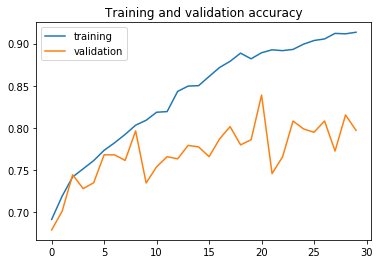

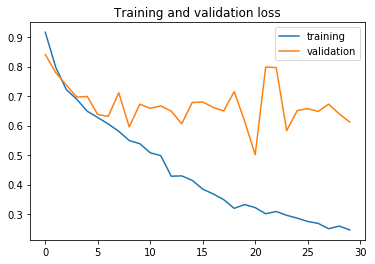

In [27]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')